# Check GPU options

In [12]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1063099648144621830
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5077532672
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4273982901815446446
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Import needed libraries

In [16]:
# Import general purpose python libraries
import os
from matplotlib import pyplot
from PIL import Image # For handling the images
import numpy as np
from sklearn import metrics
import pandas as pd
# Import different Keras functionalities
import tensorflow as tf
from tensorflow import keras
from keras.constraints import maxnorm
from keras.utils import np_utils
#from tensorflow.keras.optimizers import SGD,Adagrad
from keras.optimizers import SGD,Adagrad
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import backend as K
#from keras.applications import ResNet50,Xception,VGG16,VGG19
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from plotcm import plotcm

####
# Where to save the figures
IMAGES_PATH = "../images"
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        pyplot.tight_layout()
    pyplot.savefig(path, format=fig_extension, dpi=resolution)
from utils import saveFigures,write_json,create_json,load_previous_weights

from models import VGG16, MLP_model,VGG19,Transfer_model

ImportError: cannot import name 'Transfer_model' from 'models' (d:\Users\Fons\OneDrive - Universidad Politécnica de Madrid\UNIVERSIDAD\MASTER\Segundo curso\Primer semestre\MLLB\Proyecto DEEP\MLLB-DL-Project\models.py)

In [ ]:
config = tf.compat.v1.ConfigProto()
## ask for GPU memory gracefully
config.gpu_options.allow_growth = True

sess = tf.compat.v1.Session(config=config)

tf.compat.v1.keras.backend.set_session(sess)

# Load data

In [ ]:
cifar10 = keras.datasets.cifar10
(X_train_full, y_train_full), (X_test, y_test) = cifar10.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=1)

X_train = X_train/255.
X_valid = X_valid/255.
X_test = X_test/255.

y_train = np_utils.to_categorical(y_train)
y_valid = np_utils.to_categorical(y_valid)
y_test = np_utils.to_categorical(y_test)

num_classes = y_test.shape[1]
class_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

print("num_training_samples: ", X_train.shape)

num_training_samples:  (40000, 32, 32, 3)


# Configuration parameters
Configuration values of different parts of the solution. You should change some of them to obtain better results.

In [ ]:
from datetime import datetime
# Randomize the initial network 
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)


# Directory where to store weights of the model and results
now = datetime.now()
current_time = now.strftime("%d_%H_%M_%S")
experiment_rootdir = "./test/"+current_time+"/"
weights_path = experiment_rootdir +"weights.h5"
weights_best_path = experiment_rootdir +"weights_best.h5"
'''
weights_augmentation_path = experiment_rootdir +"weights_augmentation.h5"
weights_augmentation_best_path = experiment_rootdir +"weights_augmentation_best.h5"
'''
json_path = experiment_rootdir +"experiment.json"

# Create experiment directory if it does not exists
if not os.path.exists(experiment_rootdir):
    os.makedirs(experiment_rootdir)
print(experiment_rootdir)

./test/12_19_36_06/


In [ ]:
# Parameters that configures the training process

# Tunable parameters
name_model = "VGG16_data_augmentation"
initial_lr = 5e-2
n_hidden = 0

## Regularizarion
l2_reg = 0
dropout = 0
batch_norm = False
data_augmentation = False

# Constant parameters
compile_parameters = { "metrics": ['accuracy'], "optimizer": SGD(learning_rate=initial_lr)}

batch_size = 512 
epochs = 200
initial_epoch = 0 
num_classes = 10

checkpoint_cb = ModelCheckpoint(weights_best_path,save_best_only=True)
early_stopping_cb = EarlyStopping(patience=25,restore_best_weights=True)
'''
optimizer=  = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
'''

parameters = {
    "name_model":name_model,
    "compile_parameters" :str(compile_parameters) ,
    "l2_reg" : l2_reg,
    "batch_size": batch_size,
    "epochs": epochs, 
    "initial_epoch":initial_epoch, 
    "initial_lr": initial_lr,
    "num_classes": num_classes,
    "dropout": dropout,
    "batch_norm": batch_norm,
    "data_aug" : data_augmentation
}
create_json({"parameters":parameters}, json_path)


In [ ]:
def trainModel(model,compile_parameters,X_train, y_train, validation_data, epochs, batch_size, experiment_rootdir, weights_path, json_path,datagen, callbacks,name=''):

    model.compile(loss='categorical_crossentropy', optimizer=compile_parameters['optimizer'], metrics=compile_parameters['metrics'])
    print(model.summary())

    history=model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                steps_per_epoch = (len(X_train)//batch_size), epochs=epochs, 
                validation_data=validation_data,
                validation_steps=(len(X_train)*0.2//batch_size),
                callbacks = callbacks)
    hist_df = pd.DataFrame(history.history) 
    weights_path
    data = {"train_result"+name:hist_df.to_dict()}
    
    model.save_weights(weights_path)
    write_json(data,json_path)
    return history

# Training 

In [ ]:
# Data augmentation
# set up image augmentation
rotation_range=45
horizontal_flip=True
zoom_range=0.3
datagen = ImageDataGenerator(
    rotation_range=rotation_range if data_augmentation else 0,
    horizontal_flip=horizontal_flip if data_augmentation else 0,
    zoom_range=zoom_range if data_augmentation else 0)
 
# datagen.fit(X_train)
# for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=4, seed=499):
#   print (X_batch.shape)
#   for i in range(0,4):
#     pyplot.subplot(220 +1 +i)
#     pyplot.imshow(X_batch[i])
#   pyplot.show()
#   break
# train with image augmentation

augmentation_parameters = {
    "used": str(data_augmentation),
    "rotation_range":str(rotation_range),
    "horizontal_flip":str(horizontal_flip),
    "zoom_range":str(zoom_range)
}
write_json({"augmentation_parameters":augmentation_parameters}, json_path)

In [ ]:
#Get model
#model = MLP_model(dropout, num_classes=10, img_width=32, img_height=32, img_channels=3,l2_reg= l2_reg,n_hidden=n_hidden, batch_norm=batch_norm)
model = VGG16(dropout, num_classes=10, img_width=32, img_height=32, img_channels=3,l2_reg=l2_reg,batch_norm = batch_norm)
#model = Transfer_model(dropout, img_width=32, img_height=32, img_channels=3, num_classes=10,l2_reg=l2_reg, batch_norm = batch_norm)
#load weights
load_previous_weights(model,weights_best_path)

checkpoint_cb = ModelCheckpoint(weights_best_path,save_best_only=True)
early_stopping_cb = EarlyStopping(patience=25,restore_best_weights=True, monitor="val_accuracy")

#training model
val = datagen.flow(X_valid, y_valid, batch_size=batch_size)
#val =(X_valid, y_valid)
history = trainModel(model,compile_parameters,X_train, y_train, val, epochs, batch_size,experiment_rootdir,weights_path,json_path,datagen, [checkpoint_cb,early_stopping_cb])
saveFigures(experiment_rootdir, history, "accuracy", "loss")
'''
if data_augmentation ==True:
    #load weights
    load_previous_weights(model,weights_best_path)

    checkpoint_cb = ModelCheckpoint(weights_augmentation_best_path,save_best_only=True)
    early_stopping_cb = EarlyStopping(patience=25,restore_best_weights=True, monitor="val_accuracy")

    #training model
    val = datagen.flow(X_valid, y_valid, batch_size=batch_size)
    #val =(X_valid, y_valid)
    
    history = trainModel(model,compile_parameters,X_train, y_train, val, epochs, batch_size,experiment_rootdir,weights_augmentation_path,json_path,datagen, [checkpoint_cb,early_stopping_cb],"_augmentation")
    saveFigures(experiment_rootdir, history, "accuracy_augmentation", "loss_augmentation")
'''

Impossible to find weight path. Returning untrained model
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
m

'\nif data_augmentation ==True:\n    #load weights\n    load_previous_weights(model,weights_best_path)\n\n    checkpoint_cb = ModelCheckpoint(weights_augmentation_best_path,save_best_only=True)\n    early_stopping_cb = EarlyStopping(patience=25,restore_best_weights=True, monitor="val_accuracy")\n\n    #training model\n    val = datagen.flow(X_valid, y_valid, batch_size=batch_size)\n    #val =(X_valid, y_valid)\n    \n    history = trainModel(model,compile_parameters,X_train, y_train, val, epochs, batch_size,experiment_rootdir,weights_augmentation_path,json_path,datagen, [checkpoint_cb,early_stopping_cb],"_augmentation")\n    saveFigures(experiment_rootdir, history, "accuracy_augmentation", "loss_augmentation")\n'

<Figure size 432x288 with 0 Axes>

# Testing

-----------------------------------------------
Evaluation:
Average accuracy =  0.7521
-----------------------------------------------


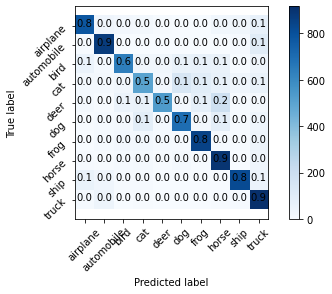

In [ ]:
y_pred = np.argmax(model.predict(X_test), axis=1)
gt = np.argmax(y_test, axis=1)

# Evaluate predictions: Average accuracy and highest errors
print("-----------------------------------------------")
print("Evaluation:")
# Compute average accuracy
ave_accuracy = metrics.accuracy_score(gt, y_pred)
print('Average accuracy = ', ave_accuracy)
print("-----------------------------------------------")

# Visualize confusion matrix                                           
plotcm(experiment_rootdir, gt, y_pred,class_names, experiment_rootdir, normalize=True)

data = {"test_accuracy":ave_accuracy}
write_json(data,json_path)



In [ ]:
#pip install playsound

#from playsound import playsound
#playsound('./sonido_fin.mp3')